# TODO: add header/description

In [1]:
import tensorflow as tf

GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
seed_file = 'seeds/3d_gesture.seed.csv'
#seed_file = 'seeds/dnn.seed.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000


In [2]:
from expansion import PatentLandscapeExpander
from word2vec import Word2Vec

expander = PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [3]:
#test_embedding = w2v_runtime.load_embedding('test')
w2v_runtime.find_similar('car', 10)

[{'distance': 0.18873202302828984, 'index': 6283, 'word': 'cars'},
 {'distance': 0.27777841887585764, 'index': 3112, 'word': 'elevator'},
 {'distance': 0.28295611080718119, 'index': 6000, 'word': 'railway'},
 {'distance': 0.30767008708779853, 'index': 6287, 'word': 'railroad'},
 {'distance': 0.36829579541764967, 'index': 9308, 'word': 'freight'},
 {'distance': 0.40134100959237196, 'index': 8236, 'word': 'floors'},
 {'distance': 0.4137411535080775, 'index': 8113, 'word': 'passengers'},
 {'distance': 0.43070808547133022, 'index': 2273, 'word': 'truck'},
 {'distance': 0.43651028262115854, 'index': 7628, 'word': 'trucks'},
 {'distance': 0.43760085223752299, 'index': 15259, 'word': 'hoistway'}]

In [4]:
training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.derive_training_data_from_seeds(seed_file)
training_data_full_df.head()

Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 26282 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (26282, 1), to patents._l1_tmp
Completed loading temp table.
Shape of L1 expansion: (133137, 3)
Got 522720 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (522720, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (495565, 3)
Size of union of [Seed, L1, and L2]: 547057
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (547057, 1), to patents.antiseed_tmp
Completed loading temp table.
Loading training data text from (16167, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (16167, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into training data.


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,2005037026,US-2005037026-A1,26748211,19971202,Prevention and treatment of amyloidogenic disease,The invention provides compositions and method...,1 . A composition comprising a fragment of Aβ ...,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...,"US-4666829-A,US-4666829-A,US-4666829-A,US-4666...","A61K2039/505,A61K9/0019,A61K47/4833,A61K9/2054...",AntiSeed
1,8045948,US-8045948-B2,40088873,20070531,"Receiving apparatus, program and receiving method",A receiving apparatus includes a receiving por...,"1. A receiving apparatus, comprising:\n a rece...",CROSS REFERENCES TO RELATED APPLICATIONS \n ...,"US-6477196-B1,US-2008298517-A1,US-7729679-B1","H04B1/001,H04B1/001,H04B1/001",AntiSeed
2,2005116101,US-2005116101-A1,34590269,20031107,Emergency oxygen or other gas supply system,Systems for supplying emergency oxygen or othe...,1 . A vehicle seat assembly comprising: \n a. ...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,"US-2931355-A,US-2931355-A,US-2931355-A,US-2931...","B64D11/00,B64D11/0629,B64D11/064,B64D2231/025,...",AntiSeed
3,3817657,US-3817657-A,5824478,19711108,Integral turbine wheel with axial through-open...,A turbine wheel in which the rim and the blade...,1. A turbine wheel having rim means and blade ...,"United States Patent [191 Hueber [451 June 18,...","US-2965355-A,US-2965355-A,US-3255994-A,US-3255...","F01D5/021,F01D5/081,F01D5/021,F01D5/081,F01D5/...",AntiSeed
4,3853646,US-3853646-A,24524820,19670405,Smokeless composite propellants containing car...,Smokeless rocket propellant compositions compr...,1. SMOKELESS ROCKET PROPELLANT COMPOSITIONS CO...,fitted Sites Patent 1191 Frankel et a1. \n [ ...,"US-3097239-A,US-3097239-A,US-3087844-A,US-3087...","C06B45/10,C06B43/00,C06B45/10,C06B43/00,C06B45...",AntiSeed


In [5]:
training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]

In [6]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    1092
title_text            1092
abstract_text         1092
claims_text           1092
description_text      1092
ExpansionLevel        1092
refs                  1092
cpcs                  1092
dtype: int64


Anti-Seed/Negative examples:
publication_number    9582
title_text            9582
abstract_text         9582
claims_text           9582
description_text      9582
ExpansionLevel        9582
refs                  9582
cpcs                  9582
dtype: int64


In [7]:
import train_data

#importlib.reload(tokenizer)

td = train_data.LandscapeTrainingData(training_df, w2v_runtime)
td.prepare_training_data(training_df.abstract_text, 0.8, 50000, 500)


Using TensorFlow backend.


Randomizing training data
Creating NumPy arrays for train/test set out of randomized training data.
Train (embed) data shapes: train: (8539,), train labels shape: (8539,)
Test (embed) data shape: (2135,), test labels shape: (2135,)
doc lengths for embedding layer: median: 103, mean: 105.21641878440099, max: 3546
Using sequence length of 3546 to pad LSTM sequences.
Training data ready.


In [12]:
def show_instance_details(training_data, training_data_series, idx):
    print('\nOriginal: {}\nTokenized: {}\nIntegerized: {}\nLabelIntegerized: {}'.format(
        training_data_series[idx],
        training_data.to_text(training_data.prepped_embedding_train[idx]),
        training_data.prepped_embedding_train[idx],
        training_data.prepped_labels[idx]))

show_instance_details(td, td.series_text_to_embed, 0)



Original: The invention provides compositions and methods for treatment of amyloidogenic diseases. Such methods entail administering an agent that induces a beneficial immune response against an amyloid deposit in the patient. The methods are particularly useful for prophylactic and therapeutic treatment of Alzheimer&#39;s disease. In such methods, a suitable agent is Aβ peptide or an antibody thereto.
Tokenized: invention provides compositions and methods for treatment of amyloidogenic diseases such methods entail administering an agent that induces a beneficial immune response against an amyloid deposit in patient methods are particularly useful for prophylactic and therapeutic treatment of alzheimer _NUMBER_ s disease in such methods a suitable agent is UNK peptide or an antibody thereto
Integerized: [45, 135, 400, 3, 155, 9, 401, 2, 36877, 1681, 42, 155, 20187, 2594, 8, 374, 19, 6564, 1, 6146, 3926, 230, 317, 8, 9648, 3212, 6, 606, 155, 13, 507, 442, 9, 8714, 3, 1882, 401, 2, 6804

In [316]:
# finding a positive example and showing some details
print_idx = 0
for row in td.trainY:
    if td.trainY[print_idx] == 0:
        break
    else:
        print_idx += 1

print('Using index {}.'.format(print_idx))
print(td.trainEmbedX[print_idx])
print(td.to_text(td.trainEmbedX[print_idx]))
print(td.trainY[print_idx])

Using index 29.
[1, 375, 378, 9, 4908, 10267, 69, 1, 375, 778, 9, 2595, 8804, 2, 1, 124, 75, 778, 7, 140, 269, 2, 1316, 6, 1295, 83, 8, 59, 378, 166, 10, 375, 778, 9, 365, 1, 47, 2, 777, 10267, 15, 8804, 2178, 12, 375, 778, 3, 1, 276, 166, 10, 59, 378, 79, 276, 38, 20, 6, 1, 14195, 266, 11, 8, 327, 266, 3, 79, 276, 4097, 15, 14195, 266, 4, 327, 266, 52, 59, 378, 1228, 1, 7349, 2, 56, 1858, 75, 2178, 8804, 56, 1858, 65, 262, 1, 405, 17505, 3, 1087, 8, 303, 777, 3, 79, 276, 1481, 1, 2252, 849, 875, 4, 8, 286, 25, 91, 17, 777, 10267, 493, 12, 59, 378, 52, 276, 5, 6, 327, 266, 1, 30, 3, 1, 225, 2359, 165, 272, 13, 61, 309, 3, 4229]
a video processor for recognizing gestures including a video camera for capturing photographs of a region within camera _NUMBER_ s field of view in real time an image processor coupled with video camera for detecting a plurality of hand gestures from photographs captured by video camera and a controller coupled with image processor wherein controller can be in a

# Train LSTM Using Embeddings

# Keras LSTM Model

### Hyperparameters

In [319]:
batch_size = 32
dropout_pct = 0.2

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128


In [321]:
print('Build model...')

refs = Sequential()
refs.add(
    Dense(
        256,
        input_dim=td.trainRefsOneHotX.shape[1],
        name='refs',
        activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())
refs.add(Dense(64, activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())

cpcs = Sequential()
cpcs.add(
    Dense(
        32,
        input_dim=td.trainCpcOneHotX.shape[1],
        name='cpcs',
        activation=None))
cpcs.add(Dropout(dropout_pct))
cpcs.add(BatchNormalization())
cpcs.add(ELU())

deep = Sequential()

embedding_layer = Embedding(td.w2v_runtime.embedding_weights.shape[0],
                            td.w2v_runtime.embedding_weights.shape[1],
                            weights=[td.w2v_runtime.embedding_weights],
                            #input_length=sequence_len,
                            trainable=False,
                            name='embed')
deep.add(embedding_layer)
'''
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
'''
deep.add(LSTM(
    lstm_size,
    dropout=0.2,
    recurrent_dropout=0.2,
    return_sequences=False,
    name='LSTM_1'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name='LSTM_2'))
deep.add(Dense(300, activation=None))
deep.add(Dropout(dropout_pct))
deep.add(BatchNormalization())
deep.add(ELU())


model = Sequential()
#model.add(concatenate([wide, deep], axis=1))
model.add(Merge([refs, cpcs, deep], mode='concat', concat_axis=1))
cpcs.add(Dense(64, activation=None))
cpcs.add(Dropout(dropout_pct))
cpcs.add(BatchNormalization())
cpcs.add(ELU())
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])


print('Train...')
#for seq, label in zip(trainX, trainY):
#    print('fitting\n seq: {} \n label: {}\n'.format(seq, label))
#    model.train_on_batch(np.array([seq]), [label])

model.fit(x={
            'refs_input': td.trainRefsOneHotX,
            'embed_input': td.padded_train_embed_x,
            'cpcs_input': td.trainCpcOneHotX},
          y=td.trainY,
          batch_size=batch_size,
          epochs=5,
          validation_data=(
              {
                  'refs_input': td.testRefsOneHotX,
                  'cpcs_input': td.testCpcOneHotX,
                  'embed_input': td.padded_test_embed_x},
              td.testY))


Build model...


/usr/local/google/home/feltenberger/anaconda3/envs/pl35/lib/python3.5/site-packages/ipykernel/__main__.py:65: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train...
Train on 8576 samples, validate on 2145 samples
Epoch 1/5
8576/8576 [==============================] - 142s - loss: 0.1001 - acc: 0.9665 - precision: 0.9848 - recall: 0.9774 - fmeasure: 0.9794 - val_loss: 0.0569 - val_acc: 0.9874 - val_precision: 0.9865 - val_recall: 1.0000 - val_fmeasure: 0.9931
Epoch 2/5
8576/8576 [==============================] - 144s - loss: 0.0397 - acc: 0.9868 - precision: 0.9913 - recall: 0.9941 - fmeasure: 0.9926 - val_loss: 0.0308 - val_acc: 0.9893 - val_precision: 0.9924 - val_recall: 0.9959 - val_fmeasure: 0.9940
Epoch 3/5
8576/8576 [==============================] - 143s - loss: 0.0184 - acc: 0.9935 - precision: 0.9952 - recall: 0.9976 - fmeasure: 0.9963 - val_loss: 0.0329 - val_acc: 0.9888 - val_precision: 0.9889 - val_recall: 0.9989 - val_fmeasure: 0.9938
Epoch 4/5
8576/8576 [==============================] - 144s - loss: 0.0130 - acc: 0.9960 - precision: 0.9970 - recall: 0.9985 - fmeasure: 0.9977 - val_loss: 0.0466 - val_acc: 0.9855 - val_preci

In [320]:
score, acc, p, r, f1 = model.evaluate(
    x={'refs_input': td.testRefsOneHotX, 'embed_input': td.padded_test_embed_x},
    y=test_y,
    batch_size=batch_size)

print('')
print('Test score: {:.4f}'.format(score))
print('Test accuracy: {:.4f}'.format(acc))
print('Test p/r (f1): {:.2f}/{:.2f} ({:.2f})'.format(p, r, f1))


2145/2145 [==============================] - 7s     

Test score: 0.0665
Test accuracy: 0.9776
Test p/r (f1): 0.98/1.00 (0.99)


------


## TensorFlow LSTM Graph

In [30]:
lstm_size = 256
lstm_layers = 1
batch_size = 128
learning_rate = 0.001
vocab_size = w2v_runtime.embedding_weights.shape[0]
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = w2v_runtime.embedding_weights.shape[1]

epochs = 10


In [31]:
# Create the graph object
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    embedding = tf.get_variable(
        name="embedding",
        shape=w2v_runtime.embedding_weights.shape,
        initializer=tf.constant_initializer(w2v_runtime.embedding_weights),
        trainable=False)
    embed = tf.nn.embedding_lookup(embedding, inputs_)

    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [32]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [33]:

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph, config=GPU_MEM_CONFIG) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(test_x, test_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")


Epoch: 0/10 Iteration: 5 Train loss: 0.134
Epoch: 0/10 Iteration: 10 Train loss: 0.102
Epoch: 0/10 Iteration: 15 Train loss: 0.131
Epoch: 0/10 Iteration: 20 Train loss: 0.086
Epoch: 0/10 Iteration: 25 Train loss: 0.121
Val acc: 0.884
Epoch: 0/10 Iteration: 30 Train loss: 0.083
Epoch: 0/10 Iteration: 35 Train loss: 0.064
Epoch: 0/10 Iteration: 40 Train loss: 0.211
Epoch: 0/10 Iteration: 45 Train loss: 0.101
Epoch: 0/10 Iteration: 50 Train loss: 0.065
Val acc: 0.910
Epoch: 0/10 Iteration: 55 Train loss: 0.092
Epoch: 0/10 Iteration: 60 Train loss: 0.051
Epoch: 0/10 Iteration: 65 Train loss: 0.053
Epoch: 0/10 Iteration: 70 Train loss: 0.037
Epoch: 0/10 Iteration: 75 Train loss: 0.038
Val acc: 0.933
Epoch: 1/10 Iteration: 80 Train loss: 0.039
Epoch: 1/10 Iteration: 85 Train loss: 0.079
Epoch: 1/10 Iteration: 90 Train loss: 0.056
Epoch: 1/10 Iteration: 95 Train loss: 0.033
Epoch: 1/10 Iteration: 100 Train loss: 0.042
Val acc: 0.949
Epoch: 1/10 Iteration: 105 Train loss: 0.057
Epoch: 1/10 Ite

In [39]:

test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(l1_x, l1_y, batch_size), 1): #can also use test_x, test_y
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test accuracy: 0.335


# Inference! (Ignore everything below here for now)

In [21]:
import importlib

import expansion

importlib.reload(expansion)
expander = expansion.PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


In [22]:

#training_df[training_df.abstract_text.str.contains('learn') & training_df.abstract_text.str.contains('machine')]

#training_df[training_df.abstract_text.str.contains('machine')]
l1_texts = expander.load_training_data_from_pubs(l1_patents_df[['publication_number']])
l1_texts['label'] = 'Seed'
l1_texts.head()


Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (133137, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.


GenericGBQException: Reason: apiLimitExceeded, Message: API limit exceeded: Unable to return a row that exceeds the API limits. To retrieve the row, export the table.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def binary_prediction_idx(score):
    if score < .5:
        return 0
    return 1

def predictions_for_report(patent_model, validX, validY):
    target_names = ['seed', 'antiseed']

    prediction_scores = patent_model.predict(validX)
    predictions = []
    actual_y = []

    for idx in range(0, len(prediction_scores)):
        prediction = prediction_scores[idx]
        actual = validY[idx]
        predictions.append(binary_prediction_idx(prediction[0]))
        actual_y.append(actual)

    return predictions, actual_y, target_names


In [41]:
import pandas as pd
l1_texts_subset = l1_texts.abstract_text[:10000]
l1_texts_subset.reset_index(drop=True, inplace=True)
l1_texts_subset.loc[len(l1_texts_subset)-1] = 'this abstract is about something entirely boring'

l1_labels_subset = l1_texts.label[:10000]
l1_labels_subset.reset_index(drop=True, inplace=True)
l1_labels_subset.loc[len(l1_texts_subset)-1] = 'AntiSeed'

print('Prepping series (tokenization etc.) for training.')
l1_x, l1_y = prep_series_for_training(w2v_runtime, l1_texts_subset, l1_labels_subset)
l1_x = np.array(l1_x)
l1_y = np.array(l1_y)

print('Padding sequences.')
# Convert text idx into padded sequences
l1_x = sequence.pad_sequences(
        l1_x, maxlen=sequence_len, padding='pre', truncating='post')
# Converting labels to binary vectors
#l1_y = to_categorical(l1_y, nb_classes=2)

print('Making predictions')
l1_preds, actual_l1_y, target_names = predictions_for_report(model, l1_x, l1_y)

cr = classification_report(l1_preds, actual_l1_y, target_names=target_names)
cm = confusion_matrix(l1_preds, actual_l1_y)
print(cr)
print(cm)
#l1_texts_subset

Prepping series (tokenization etc.) for training.
Padding sequences.
Making predictions
             precision    recall  f1-score   support

       seed       0.31      1.00      0.47      3070
   antiseed       1.00      0.00      0.00      6930

avg / total       0.79      0.31      0.14     10000

[[3070    0]
 [6929    1]]


In [120]:
#print(l1_preds)
l1_preds_df = pd.DataFrame(l1_preds, columns=['PredictionIdx'])
l1_preds_df['Prediction'] = l1_preds_df.PredictionIdx.apply(label_id_to_text)
l1_preds_df

,PredictionIdx,Prediction
0,1,antiseed
1,1,antiseed
2,1,antiseed
3,0,seed
4,1,antiseed
5,1,antiseed
6,1,antiseed
7,1,antiseed
8,1,antiseed
9,1,antiseed


In [114]:
l1_texts_subset[1]

'The present invention relates to a method for detecting fetal Down syndrome (Trisomy 21), trisomy 13, trisomy 18 and other chromosomal anomalies during prenatal screening by analyzing a dried blood sample from a pregnant woman. More particularly the present invention relates to a method for improving detection efficiency in screening for the anomalies by measuring the amount of the free beta human chorionic gonadotropin (HCG) and nicked or fragmented or aberrant forms of free beta (HCG), all of which are referenced throughout this application as free beta (HCG) in dried blood samples from pregnant women.'

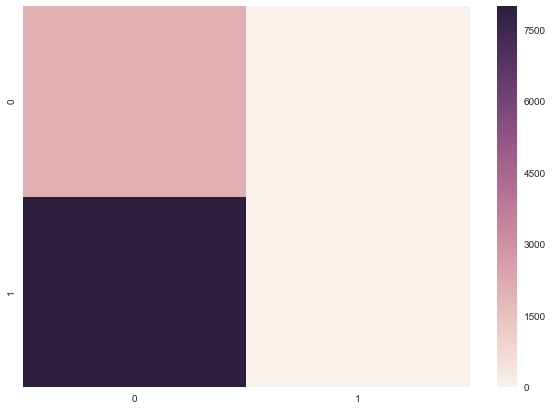

In [93]:
%matplotlib inline

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(cm_df)

In [23]:
import pandas as pd

def make_prediction(patent_model, text, expected_label, max_seq_len, mask_idx=0):
    inf_series = pd.Series([text])
    lab_series = pd.Series([label])

    prepped_train, prepped_labels = \
        prep_series_for_training(
            w2v_runtime=w2v_runtime,
            labels_series=lab_series,
            raw_series_text=inf_series)

    # make sure we have the correct sequence length
    #infX = pad_sequences(prepped_train, maxlen=max_seq_len, value=mask_idx)
    infX = sequence.pad_sequences(
        prepped_train, maxlen=sequence_len, padding='pre', truncating='post')
    #prepped_train = np.array(prepped_train)

    # actually make prediction
    prediction = patent_model.predict(infX)

    return prediction


In [34]:
model.save(filepath='checkpoints/keras_model.ckpt')

In [33]:
text = 'a really boring title that is super long and has nothing to do with the topic that im interested in. but has a bit of stuff about artificial neural networks and things i haven\'t heard of?'
text = 'three dimensional mapping'
#text = l1_texts_subset[10]
label = 'Seed'
prediction = make_prediction(model, text, expected_label=label, max_seq_len=sequence_len)
print('Text: {}'.format(text))
#print('Tokenized/Integerized: {}'.format(prepped_train))
#print('Padded: {}'.format(infX))
print('Prediction: {}'.format(prediction))
print('Predicted Label: {}, Actual Label: {}'.format(label_id_to_text(binary_prediction_idx(prediction)), label))


Text: three dimensional mapping
Prediction: [[ 0.98487407]]
Predicted Label: antiseed, Actual Label: Seed


In [302]:
#oldidx = print_idx
#print_idx = oldidx
#print(model.predict([trainX[print_idx]]))
#tensor_label_to_text(trainY[print_idx])